# JPE cleaning
This notebook walks through how the JPE articles were sorted into categories of articles and non-articles.

## Loading libraries

In [5]:
from tokenize import Ignore
from numpy import NaN
import pandas as pd
from difflib import SequenceMatcher
import multiprocessing as mp
import time
from os import path
import os
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re


## Loading Files
Please replace file paths with local file paths and comment out unapplicable content eg: datadump

In [68]:
masters = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\Master lists\\JPE_master.xlsx")
pivots = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\pivots\\JPE_pivots.xlsx")
scopus = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\Scopus\\JPE_SCOPUS.xlsx")
datadump = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\datadumps\\JPE_datadump.xlsx")

pd.set_option('display.max_colwidth', None)

## Create File names
Again, replace these with local file paths

In [ ]:
authors="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\JPE_authors.xlsx"
non_auth="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\JPE_Nauthors.xlsx"
saveas="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\JPE_processed.xlsx"
reviews="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\JPE_reviews.xlsx"
misc="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\JPE_misc.xlsx"
conf="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\JPE_conf.xlsx"

## Some random checks on the masters list
My assumption is that all data without author names must be miscellaneous documents like reports by the committee, forewords, front matters etc.. The goal of this notebook is to check for certain that all the documents without author names are actually miscellaneous documents and then classify them as miscellaneous (MISC). Hence, first we group everything the data by title to see the repetitive general content that can likely be removed.

In [ ]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp[temp>1])

Some repetitions are due to multiple comments. Now consider this list in absence of author names.

In [ ]:
temp2=masters[masters['authors'].isna()]['title'].str.lower().value_counts()
pd.DataFrame(temp2)

## Classifying miscellaneous documents

In [ ]:
scopus.rename(columns = {'abstract':'abstract2', 'title':'title2', 'authors':'authors2'}, inplace = True)
scopus['pages2']=scopus['pages']
masters['pages']=masters['pages'].str.strip()
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = NaN

masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'front matter').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'back matter').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'volume information').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'books recieved').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'washington notes').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters['title'].str.lower().str.match(r'(in )?memori(a|u)(m|l)')==True, 'content_type']='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'books reccieved').ratio(), axis=1)>0.75,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^journal of political economy(.*)')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^index to volume(.*)')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^new publications')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^(prefatory |\[)note(|s)(|\])$')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^(|\[)questions and answers(\]|)$')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^(|short )notice(|s)$')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^back cover(.*)')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^introduction(.*)')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^combined references(.*)')==True,'content_type']='MISC'

## Classifying other content types

In [ ]:
# check for how many articles are still unclassified
sum(masters.content_type.isna())
#masters.shape[0]

In [ ]:
masters.loc[masters['authors'].str.lower().str.match(r'^review(ed|) by(.*)')==True,'content_type']='Review' #reviews
masters.loc[(masters['title'].str.lower().str.match(r'(.*) by (.*)')==True) & (masters.authors.isna()==True),'content_type']='Review2' 
#possible reviews that don't have author names


In [ ]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )comment(|.*)$')==True,'content_type']='Comment'
masters[masters['content_type']=='Comment'].shape[0] #comments

In [ ]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )reply(| to.*)$')==True,'content_type']="Reply"
masters[masters['content_type']=='Reply'].shape[0]

In [ ]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True,'content_type']="Rejoinder"
masters[masters['content_type']=='Rejoinder'].shape[0]

In [ ]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(^|a )discussion(|.*)$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*:.*(|a )discussion(|s)$')==True,'content_type']='Discussion'
masters[masters['content_type']=='Discussion'].shape[0]

In [ ]:
masters.loc[masters['content_type'].isna(),'content_type']="Article"
masters[masters['content_type']=='Article'].shape[0]

In [ ]:
# block for testing regex matches
#masters[masters['title'].str.lower().str.match(r'^\washington notes$')==True]
#masters[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True]
#masters[masters.content_type=='Discussion'].shape[0]

## Consider the pivots file
At times, conference papers are structured differently to normal articles. Hence, it may be necessary to distinguish conference papers from common articles. Separate special issues (S) from normal issues (N)

In [ ]:
pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'(.*)(supplement|proceedings|annual meeting|survey)(.*)'),'type']="S"
pivots.loc[pivots.type.isna(),'type']='N'
pivots.type.value_counts()
pivots[pivots.type=="S"]

Merge pivots and masters together

In [ ]:
result = pd.merge(masters, pivots[['issue_url','year','volume','issue','journal','type']], how="left", on=["issue_url", "issue_url"])

## Summaries of content 

In [ ]:
pd.DataFrame(result.content_type.value_counts())

In [ ]:
pd.DataFrame(result[result.year>1939].content_type.value_counts())

In [ ]:
pd.DataFrame(result[(result.year>1939) & (result.year<2011)].content_type.value_counts())

In [ ]:
result.to_excel(saveas, index=False)

## This section aims to match up Scopus records and Jstor articles
If an article's affiliations, citations or abstracts are recorded on Scopus. matching up the Scopus data is useful for comparing the textual accuracy of OCR parsers. I use volume, issue, year and page numbers which are common to both the scopus data and the Jstor metadata to match articles. 

Then I use a sequence comparison between the journal titles of the matched articles to decide if the scopus data has been matched correctly. If the match ratio is below 70%, the title is investigated and if wrong, the scopus data for that matched article is either corrected or discarded. 

The next section reads in the processed data previously saved. Please make sure the path in the variable 'cleaned' matches the file path on your local machine.

In [69]:
cleaned=pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\processed\\JPE_processed.xlsx')
cleaned['volume']=cleaned['volume'].astype(str)
scopus['pages']=scopus['pages'].str.strip()
#print(scopus.shape)

This is the number of entries on Scopus

In [70]:
#Note that we only have data up to 2016 in the masterlists because of the moving wall on JSTOR
print(sum(scopus['year']<2016))

965


Merge on year, issue, volume and pages.

In [71]:
Merged=pd.merge(cleaned, scopus, on=['year', 'issue','volume','pages'], how='left')
pd.set_option('display.max_columns', None)

Check how many of the scopus entries matched. Good news! Only 9 did not match

In [72]:
sum(Merged['title_y'].isna()==False)

956

Consider the titles that have a less than 70% match.

In [73]:
count=0
for m in Merged.index:
    
    if(pd.isna(Merged.iloc[m]['title_y'])==False):
        ratio=SequenceMatcher(None, Merged.iloc[m]['title_x'].lower(), Merged.iloc[m]['title_y'].lower()).ratio()

        if((ratio<0.7) & (Merged.iloc[m]['content_type']!='MISC')):
            print(Merged.iloc[m]['year'])
            print(ratio)
            count+=1
            A_ratio=SequenceMatcher(None, Merged.iloc[m]['authors_x'].lower(), Merged.iloc[m]['authors_y'].lower()).ratio()
            print(A_ratio)
            print(Merged.iloc[m]['stable_url'])
            print('vol: '+str(Merged.iloc[m]['volume']))
            print('issue: '+str(Merged.iloc[m]['issue']))
            print('pages: '+Merged.iloc[m]['pages'])
            print('jstor: '+Merged.iloc[m]['title_x'])
            print('scopus: '+Merged.iloc[m]['title_y'])
            print('jstor: '+Merged.iloc[m]['authors_x'])
            print('scopus: '+Merged.iloc[m]['authors_y'])
            print('scopus index: '+str(scopus[scopus['title']==Merged.iloc[m]['title_y']].index))
            print(m)
            print()
print(count)

2016
0.25757575757575757
0.18181818181818182
https://www.jstor.org/stable/26549907
vol: 124
issue: 5
pages: 1466-1514
jstor: Thomas Jefferson on the “Public Good” Nature of Knowledge
scopus: Downward nominal wage rigidity, currency pegs, and involuntary unemployment
jstor: Marcos Dal Bianco
scopus: Schmitt-Grohé, S.--a--
Uribe, M.--b-- 
scopus index: Int64Index([1014], dtype='int64')
20

2016
0.2857142857142857
0.23684210526315788
https://www.jstor.org/stable/26549896
vol: 124
issue: 4
pages: 1187-1234
jstor: “Market for Lemons” Applied to Social Groups
scopus: Intermittency and the value of renewable energy
jstor: Joshua S. Goodman
scopus: Gowrisankaran, G.--a--
Reynolds, S.S.--b--
Samano, M.--c-- 
scopus index: Int64Index([1021], dtype='int64')
30

2016
0.24390243902439024
0.17391304347826086
https://www.jstor.org/stable/26549885
vol: 124
issue: 3
pages: 826-878
jstor: The Gambler’s Fallacy in Existentialist Tragicomedy
scopus: Capabilities, wealth, and trade
jstor: James Marrone
sco

Manually correct some errors in both data sets

In [74]:
cleaned.at[20, 'pages']=float('nan')
cleaned.at[30, 'pages']=float('nan')
cleaned.at[39, 'pages']=float('nan')
cleaned.at[48, 'pages']=float('nan')
scopus.at[633, 'title']='Erratum: The accident externality from driving'

Re-merge the scopus data and the cleaned masterlists

In [75]:
Merged=pd.merge(cleaned, scopus, on=['year', 'issue','volume','pages'], how='left')

Check for whether there is an issue in document type

In [76]:
pd.DataFrame(Merged[Merged['document type'].str.len()>100])

,stable_url,authors_x,title_x,abstract_x,content_type,issue_url,pages,year,volume,issue,journal_x,type,authors_y,title_y,journal_y,DOI,affiliations,abstract_y,citations,document type,index keywords,author keywords


## Merge datadump.xlsx

Datadump.xlsx contains reference metadata scraped from JSTOR during sessions running Stage_2_scraper.py. This section merges both the scopus and cleaned data with the references from datadumps. Then this is saved as an excel file. replace path as necessary.

In [77]:
Merged=pd.merge(Merged,datadump[['stable_url', 'footnotes','raw','references']], on=['stable_url'], how='left')

In [ ]:
Merged.rename(columns = {'authors_x':'Jstor_authors', 'title_x':'Jstor_title', 'abstract_x':'Jstor_abstract', 'journal_x':'Jstor_journal', 'authors_y':'scopus_authors','title_y':'scopus_title', 'abstract_y':'scopus_abstract', 'journal_y':'scopus_journal' }, inplace = True)

Saving

In [98]:
Merged.to_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\JPE_M_sco_du.xlsx', index=False)

# Merged dataset field description

This is a description of fields in the Merged dataset that combines JPE masterlist, pivot list, Scopus data pre-2016. The Merged dataset is stored in JPE_M_sco_du.xlsx.

    'stable_url' : JSTOR url for article 
    'Jstor_authors' : Author names recorded by JSTOR
    'Jstor_title' : Title of article recorded by JSTOR
    'Jstor_abstract' : abstract recorded by JSTOR nb: this is blank at the moment
    'content_type' : Article type determined during cleaning. Includes MISC for miscellaneous, Reviews, Note, Comment, Rejoinder and Article categorizations
    'issue_url' : url of issue article belongs to on JSTOR
    'pages' : pages as recorded by JSTOR
    'year' : Year of publication recorded by JSTOR
    'volume' : Volume of article recorded by JSTOR
    'issue' : issue of article recorded by JSTOR
    'Jstor_journal' : journal name JSTOR
    'type' : Type of issue determined during cleaning. S for special issue. N for normal issue
    'scopus_authors' : Author names recorded by Scopus
    'scopus_title' : Title recorded by Scopus
    'scopus_journal' : Journal name recorded by Scopus
    'DOI' : DOI recorded by scopus
    'affiliations' : affiliations of authors as recorded by scopus
    'scopus_abstract' : abstract of article recorded by scopus
    'citations' : citations of article recorded by scopus
    'document type' : Article type recorded by scopus, may differ from that in cleaning
    'index keywords' : from scopus
    'author keywords' : from scopus
    'footnotes' : footnotes scraped from metadata panel.
    'raw' : raw text data scraped from JSTOR metadata panel.
    'references' : citations scraped from JSTOR metadata panel during data collection. 

In [ ]:
Merged=pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\JPE_M_sco_du.xlsx')

## The Tesseract library

I use Tesseract, a popular parsing library and the python binding of it pyTesseract to parse JPE documents in this section. I am  following the code and technique from this article on how to read a multi-column pdf. The fitz python module is a lightweight pdf reader, it will require the installation of pyMupdf. OpenCV python module and the module/class cv2 from it is used to apply otsu's thresholding technique to lift/determine paragraph edges. 

https://towardsdatascience.com/read-a-multi-column-pdf-with-pytesseract-in-python-1d99015f887a

In [9]:
import fitz

# for OCR using PyTesseract
import cv2                              # pre-processing images
import pytesseract                      # extracting text from images
import numpy as np
import matplotlib.pyplot as plt         # displaying output images
from PIL import Image

Set path to where pdfs of articles are.

In [103]:
path='C:\\Users\\sjwu1\\Journal_Data\\JPE_data'
temp=path+'\\dummy.pdf'

Read in the merged pdf containing jstor, scopus and datadump metadata.

In [30]:
Merged=pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\JPE_M_sco_du.xlsx')

Set the zoom factor to zoom into the pdf. This is to get a higher resolution image. I have chosen 2x zoom for both vertically and horizontally.

In [72]:
zoom_x = 2.0 # horizontal zoom
zoom_y = 2.0 # vertical zoom
mat = fitz.Matrix(zoom_x, zoom_y)

### The getNumberofPages() function
Given a text string from jstor of the page numbers of an article, this gives the number of pages expected in the article. Because some articles' pdfs are downloaded from scopus sometimes they are missing a front page. On the otherhand sometimes jstor has a coverpage that is not accounted for. This function returns the number of pages so that the first page of an article can be correctly identified.

In [34]:
def getNumberofPages(text):
    if pd.isna(text)==False:
        if re.search('\d',text):
            temp=text.split(',')
            pages=0
            print(temp)
            for m in temp:
                if '-' in m:
                    t=str(m).split('-')
                    pages=pages+int(re.sub('\D','',t[1]))-int(re.sub('\D','',t[0]))+1
                else:
                    pages+=1
            return pages
    return 1


print(getNumberofPages('2014-2016, 30'))
print(getNumberofPages('20-40'))

['2014-2016', ' 30']
4
['20-40']
21


### The converter() function
This function takes a string and replaces all non-ascii characters with a placeholder. In regex, a placeholder is represented by a '.'. Specific to JPE, a lower case 'L' and a upper case 'I' look the same to tesseract because of the font. Hence, upper case 'I's are replaced with a placeholder. I found that for middle name initials, tesseract may mistake the letter for something else  hence again, we replace it with a placeholder. 

An alternative solution is to use fuzzy matching.

In [35]:

import string
def converter(teststring):
    for i in range(len(teststring)):
        if teststring[i] == '.':
            teststring=teststring[0:i-1]+'.'+teststring[i:]
    
    teststring=teststring.replace('I','.')
            
    for i in teststring:
        if (i not in string.ascii_lowercase) & (i not in string.ascii_uppercase) & (i !=' '):
            teststring=teststring.replace(i,'.')
    return teststring


### The generate_pngs() function
This function looks for the block of text that contains author names, assuming that the block also contains affiliations. If affiliations are not found, then the parsed text is returned. Only the first page of the article and sometimes the JSTOR cover page is parsed. 

Given a pdf file path (SCANNED_FILE), the number of pages (pages), zoom matrix (mat), path to pdf file folder (path), a value for how tightly to draw mask (k_val). A higher k_val results in a mask that covers more of the page ie: segments the page less. You can uncomment the lines of code for plots inside the function observe the mask. Lastly, a string or regex pattern that would match the lead author's name.

In [ ]:
def generate_pngs(SCANNED_FILE, pages, mat, path, k_val, author):
    doc = fitz.open(SCANNED_FILE)
    parsed={}
    count=doc.page_count-pages
    if count<0:
        count=1
    for page in doc:
        if (page.number == count):
            png = path+"\\pages_png\\" + SCANNED_FILE.split('\\')[-1].split('.')[0] + '_page-%i.png' % page.number
            if os.path.exists(png)==False:
                pix = page.get_pixmap(matrix=mat)
                print(png)
                pix.save(png)

            parsed[page.number]=[]

            original_image = cv2.imread(png)
            # convert the image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(gray_image, cmap='gray')
            #plt.show()

            # Performing OTSU threshold
            ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(threshold_image, cmap='gray')
            #plt.show()

            rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_val, k_val))

            # Applying dilation on the threshold image
            dilated_image = cv2.dilate(threshold_image, rectangular_kernel, iterations = 1)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(dilated_image)
            #plt.show()

            # Finding contours
            contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Creating a copy of the image
            copied_image = original_image.copy()

            mask = np.zeros(original_image.shape, np.uint8)
            i=1
            # Looping through the identified contours
            # Then rectangular part is cropped and passed on to pytesseract
            # pytesseract extracts the text inside each contours
            # Extracted text is then written into a text file
            for cnt in reversed(contours):
                x, y, w, h = cv2.boundingRect(cnt)
                print(i)
                # Cropping the text block for giving input to OCR
                cropped = copied_image[y:y + h, x:x + w]
                # Apply OCR on the cropped image
                text = pytesseract.image_to_string(cropped, lang='lat', config='--oem 3 --psm 1')
                print(text)
                parsed[page.number].append(text)
                print(re.search(author.upper(),text.upper()))
                if re.search('AUTHOR\(S\)', text.upper()) is not None:
                    count+=1
                    break
                if re.search(author.upper(),text.upper()) is not None:
                    return {'found': text}
                #masked = cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
                print()
                i=i+1
            #plt.figure(figsize=(25, 15))
            #plt.imshow(masked, cmap='gray')
            #plt.show()
    return {'raw': parsed}


### Testing the generate_pngs() function
I use the getNumberofPages() and converter() functions as inputs.

In [ ]:
# replace with you own file
SCANNED_FILE = path+'\\1830926.pdf'

t0=time.time()        
affiliations=generate_pngs(SCANNED_FILE, getNumberofPages('339-354'), mat, path, 50, converter('Michael D. Intriligator'))
t1=time.time()
total=t1-t0
print(total)
affiliations


### Extracting affiliations from JPE
First create an empty dictionary

In [54]:
dict={}

#lower case all letters in both upper and lower
counts=Merged[(Merged['year']>1940) & (Merged['content_type']!='MISC') & (Merged['content_type']!='Review')]
counts.shape

(4430, 25)

This for loop, provided the content_type is not miscellaneous or a review, stores metadata of a paper via the JSTOR ID in the dictionary dict.

JSTOR_id: { 

    'affiliations': {'found': affiliations_text_if_found}, 
    'content_type': content_type, 
    'authors': [author1, author2, author3 ...], 
    'stable_url': stable_url]
   }
   
Note: if affiliations are not found then the 'affiliations' field will contain a dictionary of form.

'raw': {

    '0': [parsed_text_on_page_0 separated by commas], 
    '1': [parsed_text_on_page_1 separated by commas] ...
   }

In [ ]:
t0=time.time()

for i in Merged[(Merged['year']>=1940) & (Merged['content_type']!='MISC') & (Merged['content_type']!='Review')].index:
    if Merged.iloc[i]['Jstor_authors'] is not NaN: 
        if "Suggested by" not in Merged.iloc[i]['Jstor_authors']:
            authors=str(Merged.iloc[i]['Jstor_authors']).replace(' and ',', ').replace("  ",' ').split(',')
            filepath=path+'\\'+Merged.iloc[i]['stable_url'].split('/')[-1]+'.pdf'
            if os.path.exists(filepath)==True:
                print(Merged.iloc[i]['year'])
                first_author=converter(authors[0])
                print(first_author)
                n_pages=getNumberofPages(Merged.iloc[i]['pages'])
                if pd.isna(n_pages)==False:
                    affiliations=generate_pngs(filepath, n_pages, mat, path, 52, first_author.strip())
                    dict[Merged.iloc[i]['stable_url'].split('/')[-1]]={'affiliations':affiliations, 'content_type':Merged.iloc[i]['content_type'], 'authors':authors, 'stable_url': Merged.iloc[i]['stable_url']}
            else:
                dict[Merged.iloc[i]['stable_url'].split('/')[-1]]='PDF not available, download at '+ Merged.iloc[i]['stable_url']
t1=time.time()
total=t1-t0
print(total)
print(i)

Save the dictionary containing affiliations inside a json file.

In [65]:
import json
with open(path+'//JPE_affiliation_output_aff2.json','w') as fp:
    json.dump(dict, fp)

In [ ]:
import json
# print pretty to view dictionary content
print(json.dumps(dict, sort_keys=False, indent=4))
print(len(dict.keys()))

### Extracting references
JPE has references at the end in a dedicated references section from 1966 onwards. Hence the generate_refs function looks for a keyword 'References' using fuzzy matching (less that 3 character difference) and returns everything following it. If it is not found then the function returns the parsed text of the last 5 pages of the document.

In [81]:
import time
import regex
def generate_refs(SCANNED_FILE, mat, path, k_val, keyword):
    doc = fitz.open(SCANNED_FILE)
    parsed={}
    references={}
    found=0
    for page in reversed(doc):
        if (page.number >= doc.page_count-5):
            png = path+"\\pages_png\\" + SCANNED_FILE.split('\\')[-1].split('.')[0] + '_page-%i.png' % page.number
            if os.path.exists(png)==False:
                pix = page.get_pixmap(matrix=mat)
                print(png)
                pix.save(png)

            parsed[page.number]=[]
            references[page.number]=[]

            original_image = cv2.imread(png)
            # convert the image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(gray_image, cmap='gray')
            #plt.show()

            # Performing OTSU threshold
            ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(threshold_image, cmap='gray')
            #plt.show()

            rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_val, k_val))

            # Applying dilation on the threshold image
            dilated_image = cv2.dilate(threshold_image, rectangular_kernel, iterations = 1)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(dilated_image)
            #plt.show()

            # Finding contours
            contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Creating a copy of the image
            copied_image = original_image.copy()

            mask = np.zeros(original_image.shape, np.uint8)
            i=1
            # Looping through the identified contours
            # Then rectangular part is cropped and passed on to pytesseract
            # pytesseract extracts the text inside each contours
            # Extracted text is then written into a text file
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                # Cropping the text block for giving input to OCR
                cropped = copied_image[y:y + h, x:x + w]
                # Apply OCR on the cropped image
                text = pytesseract.image_to_string(cropped, lang='lat', config='--oem 3 --psm 1')
                #print(i)
                #print(text)
                parsed[page.number].append(text)
                #print(re.search(keyword.upper(),text.upper()))
                if regex.search(keyword, text.upper()) is not None:
                    print('found')
                    return {'found': parsed}
                #masked = cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
                i=i+1
    return {'raw': parsed}

### Testing the generate_pngs() function

In [76]:
t0=time.time()        
refs=generate_refs(path+'\\26549911.pdf', mat, path, 40, '\n(REFERENCES){e<=3}\n')
t1=time.time()
total=t1-t0
print(total)
refs

found
4.572999000549316


{'found': {48: ['This content downloaded from.\n137.158.158.62 on Wed, 30 Mar 2022 16:36:52 UTC\nAll use subject to https;//about jstor.org/terms\n',
   '1562 JOURNAL OF POLITICAL ECONOMY\n\nMatthews, S. A., and A. Postlewaite. 1995. *On Modeling Cheap Talk in Bayesian\nGames." In The Economics of Informational Decentralization: Complexity, Efficiency,\nand Stability; Essays in Honor of Stanley Reiter, edited by J. O. Ledyard, 347-66.\nBoston: Kluwer.\n\nRosenberg, D., E. Solan, and N. Vieille. 2013. "Strategic Information Exchange."\nGames and Econ. Behavior 82:444—067.\n\nSpence, M. 1973. "Job Market Signaling." Q. E. 87:3:\n\n'],
  47: ['This content downloaded from.\n137.158.158.62 on Wed, 30 Mar 2022 16:36:52 UTC\nAll use subject to https;//about jstor.org/terms\n',
   'SELLING INFORMATION 1561\n\nNote, however, that, because /iis no steeper than u(f)/p.\n\nVp) 8 9 - [\' e tnap\n\nL\n\n(recall that u/ (5) *- w(p)/p), and hence, replacing (f) and rearranging,\n\n1 [^\nwp) s zl wu (

create the empty dictionary

In [ ]:
dict_ref={}

This for loop, provided the content_type is not miscellaneous or a review, stores the references extracted via tesseract and metadata of a paper via the JSTOR ID in the dictionary dict.

JSTOR_id: {

    'references': {
        'found': {
            'page_no': [Text containing or following references keyword separated by commas],
            'page_no': [Text containing or following references keyword separated by commas] ...
            }
         }, 
    'content_type': content_type, 
    'authors': [author1, author2, author3 ...], 
    'stable_url': stable_url]
    }

Note: if references are not found then the 'references' field will contain a dictionary of form.

'raw': {

    'page_no': [parsed_text_on_page_no separated by commas], 
    'page_no': [parsed_text_on_page_no separated by commas] ...
    }

In [77]:
t0=time.time()

for i in Merged[(Merged['year']>1965) & (Merged['year']<=1970) & (Merged['content_type']!='MISC') & (Merged['content_type']!='Review')].index:
    if Merged.iloc[i]['Jstor_authors'] is not NaN: 
        if "Suggested by" not in Merged.iloc[i]['Jstor_authors']:
            authors=str(Merged.iloc[i]['Jstor_authors']).replace(' and ',', ').replace("  ",' ').split(',')
            filepath=path+'\\'+Merged.iloc[i]['stable_url'].split('/')[-1]+'.pdf'
            if os.path.exists(filepath)==True:
                print(Merged.iloc[i][['year','issue','volume', 'stable_url']])
                if pd.isna(n_pages)==False:
                    references=generate_refs(filepath, mat, path, 52, '(REFERENCES){e<=3}\n')
                    dict_ref[Merged.iloc[i]['stable_url'].split('/')[-1]]={'references':references, 'content_type':Merged.iloc[i]['content_type'], 'authors':authors, 'stable_url': Merged.iloc[i]['stable_url']}
            else:
                dict_ref[Merged.iloc[i]['stable_url'].split('/')[-1]]='PDF not available, download at '+ Merged.iloc[i]['stable_url']
t1=time.time()
total=t1-t0
print(total)
print(i)

year                                          1970
issue                                            6
volume                                          78
stable_url    https://www.jstor.org/stable/1830621
Name: 3824, dtype: object
['1213-1227']
found
year                                          1970
issue                                            6
volume                                          78
stable_url    https://www.jstor.org/stable/1830622
Name: 3825, dtype: object
['1228-1263']
found
year                                          1970
issue                                            6
volume                                          78
stable_url    https://www.jstor.org/stable/1830623
Name: 3826, dtype: object
['1264-1291']
found
year                                          1970
issue                                            6
volume                                          78
stable_url    https://www.jstor.org/stable/1830624
Name: 3827, dtype: object
['1292-1309']
found


found
year                                          1970
issue                                            4
volume                                          78
stable_url    https://www.jstor.org/stable/1829815
Name: 3867, dtype: object
['890-905']
found
year                                          1970
issue                                            4
volume                                          78
stable_url    https://www.jstor.org/stable/1829816
Name: 3868, dtype: object
['906-947']
found
year                                          1970
issue                                            4
volume                                          78
stable_url    https://www.jstor.org/stable/1829817
Name: 3869, dtype: object
['948-965']
found
year                                          1970
issue                                            4
volume                                          78
stable_url    https://www.jstor.org/stable/1829818
Name: 3870, dtype: object
['966-1006']
found
y

found
year                                          1970
issue                                            2
volume                                          78
stable_url    https://www.jstor.org/stable/1830687
Name: 3916, dtype: object
['274-278']
found
year                                          1970
issue                                            2
volume                                          78
stable_url    https://www.jstor.org/stable/1830688
Name: 3917, dtype: object
['279-290']
found
year                                          1970
issue                                            2
volume                                          78
stable_url    https://www.jstor.org/stable/1830689
Name: 3918, dtype: object
['291-305']
found
year                                          1970
issue                                            2
volume                                          78
stable_url    https://www.jstor.org/stable/1830690
Name: 3919, dtype: object
['306-310']
found
ye

found
year                                          1970
issue                                            1
volume                                          78
stable_url    https://www.jstor.org/stable/1829636
Name: 3956, dtype: object
['175-177']
found
year                                          1970
issue                                            1
volume                                          78
stable_url    https://www.jstor.org/stable/1829637
Name: 3957, dtype: object
['178-180']
found
year                                          1970
issue                                            1
volume                                          78
stable_url    https://www.jstor.org/stable/1829638
Name: 3958, dtype: object
['181-184']
year                                          1969
issue                                            6
volume                                          77
stable_url    https://www.jstor.org/stable/1837201
Name: 3965, dtype: object
['873-891']
found
year    

found
year                                          1969
issue                                            4
volume                                          77
stable_url    https://www.jstor.org/stable/1829322
Name: 4010, dtype: object
['586-627']
found
year                                          1969
issue                                            4
volume                                          77
stable_url    https://www.jstor.org/stable/1829323
Name: 4011, dtype: object
['628-652']
found
year                                          1969
issue                                            4
volume                                          77
stable_url    https://www.jstor.org/stable/1829324
Name: 4012, dtype: object
['653-664']
found
year                                          1969
issue                                            4
volume                                          77
stable_url    https://www.jstor.org/stable/1829325
Name: 4013, dtype: object
['665-683']
found
ye

found
year                                          1969
issue                                            2
volume                                          77
stable_url    https://www.jstor.org/stable/1829768
Name: 4061, dtype: object
['242-244']
found
year                                          1969
issue                                            2
volume                                          77
stable_url    https://www.jstor.org/stable/1829769
Name: 4062, dtype: object
['245-248']
found
year                                          1969
issue                                            2
volume                                          77
stable_url    https://www.jstor.org/stable/1829770
Name: 4063, dtype: object
['249-273']
found
year                                          1969
issue                                            2
volume                                          77
stable_url    https://www.jstor.org/stable/1829771
Name: 4064, dtype: object
['274-285']
found
ye

found
year                                          1968
issue                                            5
volume                                          76
stable_url    https://www.jstor.org/stable/1830038
Name: 4111, dtype: object
['1069-1077']
found
year                                          1968
issue                                            5
volume                                          76
stable_url    https://www.jstor.org/stable/1830039
Name: 4112, dtype: object
['1078-1084']
found
year                                          1968
issue                                            5
volume                                          76
stable_url    https://www.jstor.org/stable/1830040
Name: 4113, dtype: object
['1085-1087']
found
year                                          1968
issue                                            5
volume                                          76
stable_url    https://www.jstor.org/stable/1830041
Name: 4114, dtype: object
['1087']
found

found
year                                          1968
issue                                            4
volume                                          76
stable_url    https://www.jstor.org/stable/1830051
Name: 4152, dtype: object
['583-600']
found
year                                          1968
issue                                            4
volume                                          76
stable_url    https://www.jstor.org/stable/1830052
Name: 4153, dtype: object
['601-614']
found
year                                          1968
issue                                            4
volume                                          76
stable_url    https://www.jstor.org/stable/1830053
Name: 4154, dtype: object
['615-634']
found
year                                          1968
issue                                            4
volume                                          76
stable_url    https://www.jstor.org/stable/1830054
Name: 4155, dtype: object
['635-644']
found
ye

found
year                                          1968
issue                                            1
volume                                          76
stable_url    https://www.jstor.org/stable/1830724
Name: 4199, dtype: object
['38-43']
found
year                                          1968
issue                                            1
volume                                          76
stable_url    https://www.jstor.org/stable/1830725
Name: 4200, dtype: object
['44-52']
found
year                                          1968
issue                                            1
volume                                          76
stable_url    https://www.jstor.org/stable/1830726
Name: 4201, dtype: object
['53-67']
found
year                                          1968
issue                                            1
volume                                          76
stable_url    https://www.jstor.org/stable/1830727
Name: 4202, dtype: object
['68-77']
found
year      

found
year                                          1967
issue                                            5
volume                                          75
stable_url    https://www.jstor.org/stable/1829088
Name: 4248, dtype: object
['750-754']
found
year                                          1967
issue                                            5
volume                                          75
stable_url    https://www.jstor.org/stable/1829089
Name: 4249, dtype: object
['755-760']
found
year                                          1967
issue                                            5
volume                                          75
stable_url    https://www.jstor.org/stable/1829090
Name: 4250, dtype: object
['761-762']
found
year                                          1967
issue                                            5
volume                                          75
stable_url    https://www.jstor.org/stable/1829091
Name: 4251, dtype: object
['763-764']
found
ye

found
year                                          1967
issue                                            4
volume                                          75
stable_url    https://www.jstor.org/stable/1832173
Name: 4285, dtype: object
['651-654']
year                                          1967
issue                                            4
volume                                          75
stable_url    https://www.jstor.org/stable/1828594
Name: 4287, dtype: object
['321-334']
found
year                                          1967
issue                                            4
volume                                          75
stable_url    https://www.jstor.org/stable/1828595
Name: 4288, dtype: object
['335-351']
found
year                                          1967
issue                                            4
volume                                          75
stable_url    https://www.jstor.org/stable/1828596
Name: 4289, dtype: object
['352-365']
found
year    

found
year                                          1967
issue                                            1
volume                                          75
stable_url    https://www.jstor.org/stable/1829545
Name: 4351, dtype: object
['49-62']
found
year                                          1967
issue                                            1
volume                                          75
stable_url    https://www.jstor.org/stable/1829546
Name: 4352, dtype: object
['63-70']
found
year                                          1967
issue                                            1
volume                                          75
stable_url    https://www.jstor.org/stable/1829547
Name: 4353, dtype: object
['71-76']
found
year                                          1967
issue                                            1
volume                                          75
stable_url    https://www.jstor.org/stable/1829548
Name: 4354, dtype: object
['77-85']
found
year      

found
year                                          1966
issue                                            4
volume                                          74
stable_url    https://www.jstor.org/stable/1829155
Name: 4420, dtype: object
['396-400']
found
year                                          1966
issue                                            4
volume                                          74
stable_url    https://www.jstor.org/stable/1829156
Name: 4421, dtype: object
['401-402']
found
year                                          1966
issue                                            4
volume                                          74
stable_url    https://www.jstor.org/stable/1829157
Name: 4422, dtype: object
['403-405']
found
year                                          1966
issue                                            4
volume                                          74
stable_url    https://www.jstor.org/stable/1829158
Name: 4423, dtype: object
['406']
year        

Save references as a json file.

In [79]:
import json
with open(path+'//JPE_refs_output_1966_1970.json','w') as fp:
    json.dump(dict_ref, fp)

### Consider references for years pre-1965 (inclusive)
References are expected to be found in the footnotes from 1940 to 1965 (inclusive). Pdfminer.six is able to detect the size of the font through xml analysis. Use heuristics such as references are at the bottom of the page and of a different font type and size. 

In [83]:
from io import StringIO
from pdfminer.high_level import extract_text_to_fp
from pdfminer.layout import LAParams
from pdfminer.high_level import extract_text
# suppress logs
import logging 
logging.propagate = False
logging.getLogger().setLevel(logging.ERROR)
#https://stackoverflow.com/questions/29762706/warnings-on-pdfminer

In [ ]:
output_string = StringIO()
filepath=path+'\\composite\\2138780_comp.pdf'
with open(filepath, 'rb') as fin:
    extract_text_to_fp(fin, output_string, laparams=LAParams(), output_type='html', codec=None)

In [ ]:
for page_layout in extract_pages(filepath):
    for element in page_layout:
        print(element)


In [ ]:
for page_layout in extract_pages(filepath):
    for element in page_layout:
        if isinstance(element, LTTextContainer):
            for text_line in element:
                print(text_line)
                for character in text_line:
                    if isinstance(character, LTChar):
                        print(character.fontname)
                        print(character.size)


### Plots of counts
Exploratory analysis of available data in scopus and datadumps.

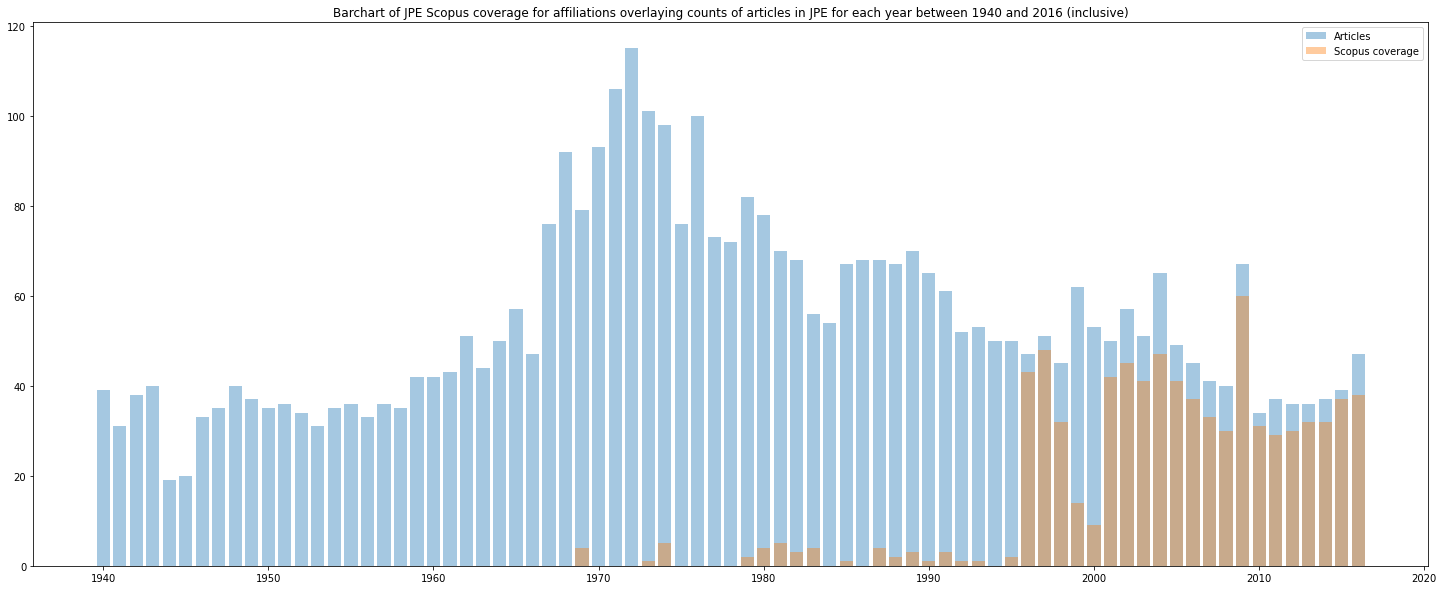

In [100]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']=='Article') & (Merged['year']>=1940)]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[Merged['affiliations'].isnull()==False]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.title('Barchart of JPE Scopus coverage for affiliations overlaying counts of articles in JPE for each year between 1940 and 2016 (inclusive)')
plt.legend()

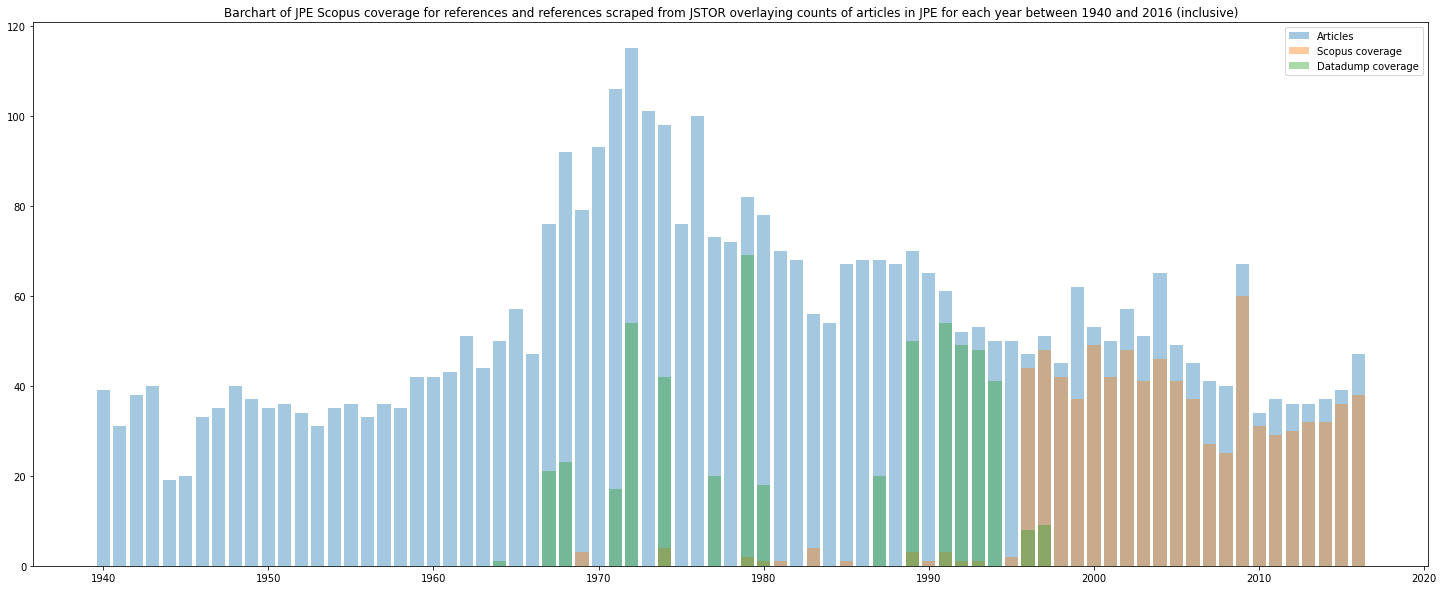

In [99]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']=='Article') & (Merged['year']>=1940)]['year'].value_counts()
dta.index
plt.bar(dta.index, dta, alpha=0.4, label='Articles')
dta3=Merged[Merged['citations'].isnull()==False]['year'].value_counts()
plt.bar(dta3.index, dta3, alpha=0.4, label='Scopus coverage')
dta4=Merged[Merged['references'].isnull()==False]['year'].value_counts()
plt.bar(dta4.index, dta4, alpha=0.4, label='Datadump coverage')
plt.title('Barchart of JPE Scopus coverage for references and references scraped from JSTOR overlaying counts of articles in JPE for each year between 1940 and 2016 (inclusive)')
plt.legend()